# Problem Set 3: Logistic Regression

# Exercise 1

Consider the following binary model
$P(Y_{i} = y_{i}) = \pi_{i}^{y_{i}}*(1-\pi_{i})^{1-y_{i}}, y_{i} \in \{0, 1\}$   
where  
$\pi_{i}(x_{i}, \beta) = \frac{e^{x'_{i}\beta}}{(1 + e^{x'_{i}\beta})} = \frac{1}{1+e^{-x'_{i}\beta}}$

1. Simulate this model with the probabilities as described above with the following values:

- $n =1000$
- $\beta_0=-2, \, \beta_1=0.1,\, \, \, \beta_2=1$.
- $x_{0i}=1 \, \forall \,i$ , $x_{1i}\sim \mathcal{U}(18,60), \, x_{2i}\sim \mathcal{B}(0.5)$. 

2. Estimate $\beta_0, \, \beta_1,\, \beta_2$ via maximum likelihood and calculate the standard errors.

$P(Y_{i} = 1) = \pi_{i}^{1}*(1-\pi_{i})^{1-1} = \pi_{i}$  
$\log(\frac{\pi_{i}}{1 - \pi_{i}}) = x'_{i}\beta$

In [1]:
# Load necessary libraries
pacman::p_load(ggplot2, tidyverse, MASS, caret, ggpubr, maxLik)

In [2]:
# Set.seed()
seed <- 40
set.seed(seed)

In [3]:
# Parameters
n <- 1000
beta <- c(-2, 0.1, 1)
X1.min <- 18
X1.max <- 60
X2.P1 <- 0.5


In [4]:
# Define Data Gnerating function
data.gen <- function(n, beta, X1.min, X1.max, X2.P1) {
  X0 <- rep(1, n)
  X1 <- sort(runif(n, X1.min, X1.max))
  X2 <- rbinom(n, 1, X2.P1)
  X <- cbind(X0, X1, X2)
  y <- rep(0, n)
  logodds <- X %*% beta
  pi_x <- 1 / (1 + exp(-(X %*% beta)))
  y <- rbinom(n, 1, prob = pi_x)
  data <- cbind.data.frame(X, logodds, pi_x, y)
  return(data)
}


## a) Generate the data

In [5]:
# a)
# Generate the training data
data.train <- data.gen(n, beta, X1.min, X1.max, X2.P1)
head(data.train)

X.train <- cbind(data.train$X0, data.train$X1, data.train$X2)
head(X.train)

# Generate the test data
data.test <- data.gen(n, beta, X1.min, X1.max, X2.P1) 
head(data.test)

X.test <- cbind(data.test$X0, data.test$X1, data.test$X2)
head(X.test)

,X0,X1,X2,logodds,pi_x,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,18.12847,1,0.8128471,0.6927159,1
2,1,18.13016,1,0.8130156,0.6927517,1
3,1,18.14943,1,0.8149429,0.6931618,0
4,1,18.16703,0,-0.1832970,0.4543036,0
5,1,18.17133,0,-0.1828666,0.4544103,1
6,1,18.21251,1,0.8212509,0.6945018,1


1,18.12847,1
1,18.13016,1
1,18.14943,1
1,18.16703,0
1,18.17133,0
1,18.21251,1


,X0,X1,X2,logodds,pi_x,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,18.08957,1,0.8089571,0.6918872,1
2,1,18.09186,0,-0.1908141,0.4524407,1
3,1,18.13831,1,0.8138309,0.6929252,1
4,1,18.17453,1,0.8174526,0.6936953,1
5,1,18.18424,1,0.8184236,0.6939016,1
6,1,18.18654,1,0.8186542,0.6939506,1


1,18.08957,1
1,18.09186,0
1,18.13831,1
1,18.17453,1
1,18.18424,1
1,18.18654,1


In [6]:
table(data.train$y)


  0   1 
136 864 

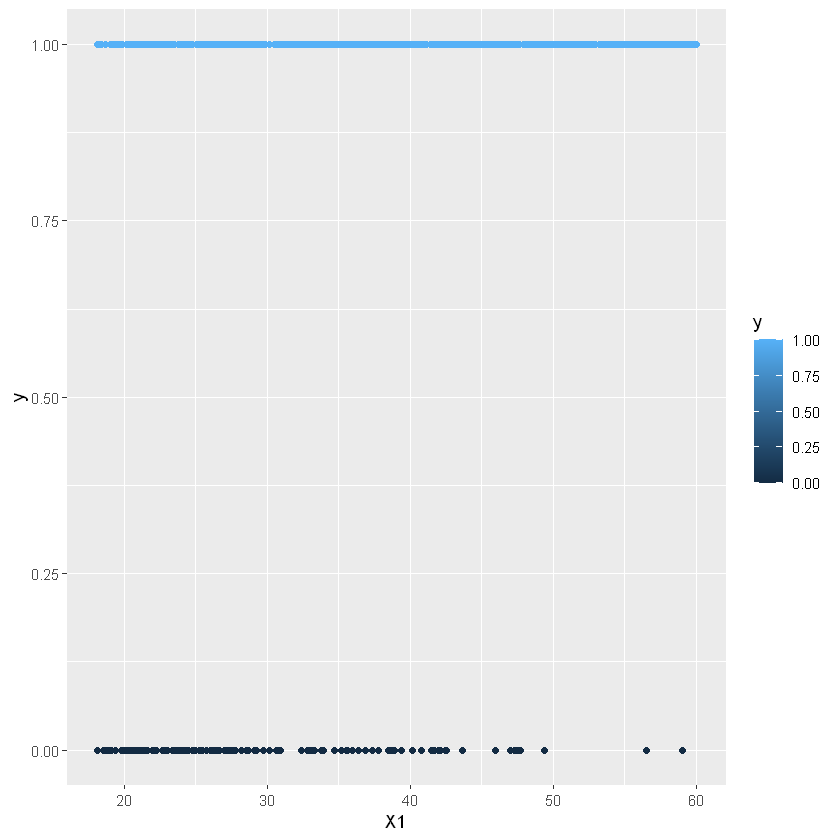

In [7]:
# Explore the data
# Scatterplot of ys on X1
ggplot(data.train, aes(x = X1, y = y, colour = y)) + 
  geom_point()

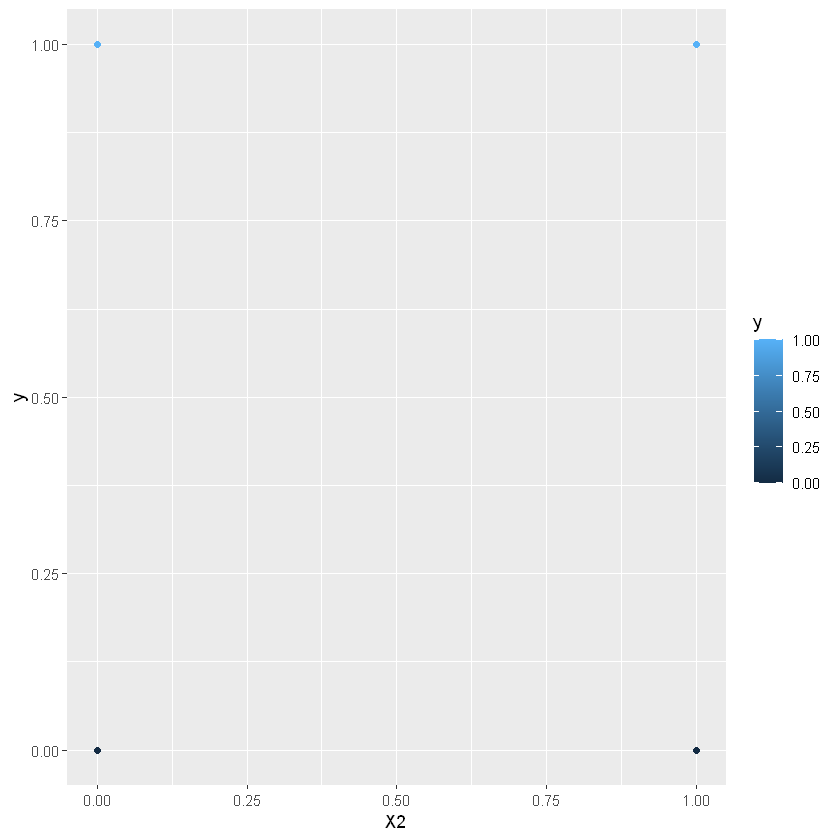

In [8]:
# ... ys on X2
ggplot(data.train, aes(x = X2, y = y, colour = y)) + 
  geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



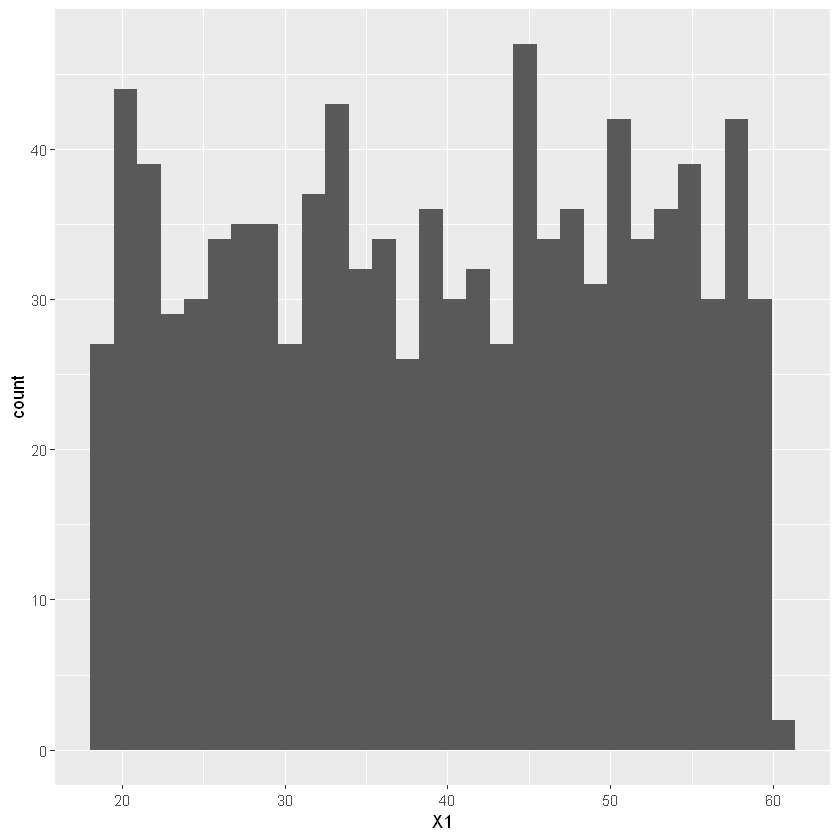

In [9]:
# Distribution of X1
ggplot(data.train, aes(X1)) + 
  geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



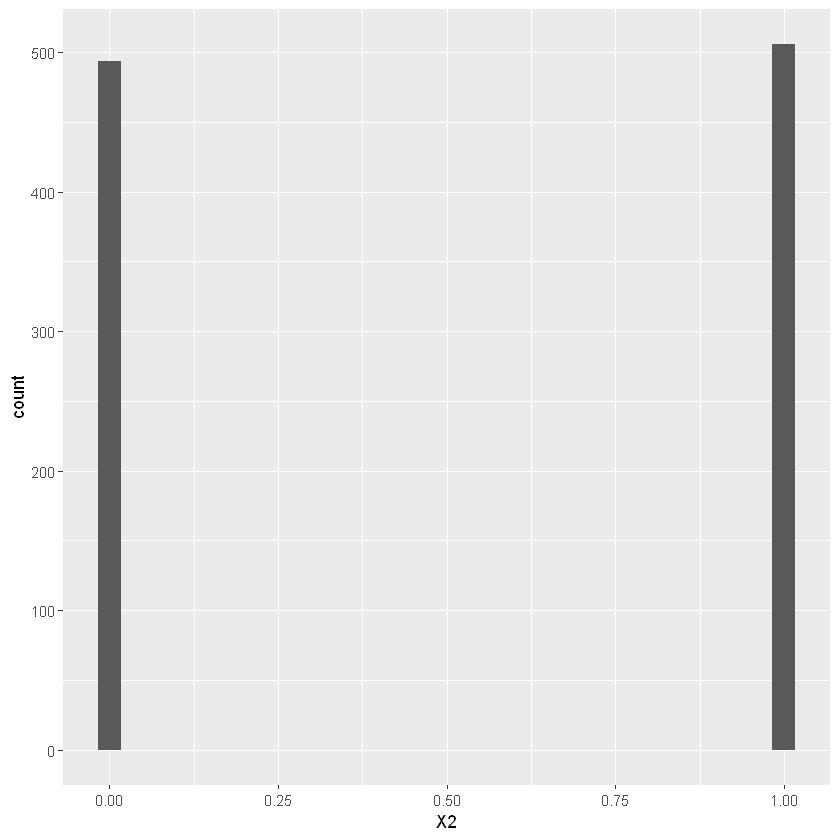

In [10]:
# Distribution of X2
ggplot(data.train, aes(X2)) + 
  geom_histogram() 


## b) Obtain the estimates


In [11]:
# b)
# Estimate betas via ML (Logistic Regression)
Logit <- glm(y ~ X1 + X2, data = data.train, family = binomial)
summary(Logit)
(beta.logit <- Logit$coefficients)


Call:
glm(formula = y ~ X1 + X2, family = binomial, data = data.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8639   0.1836   0.3147   0.5549   1.2486  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.0574     0.3570  -5.762 8.29e-09 ***
X1            0.1041     0.0106   9.820  < 2e-16 ***
X2            0.7350     0.2041   3.601 0.000317 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 795.27  on 999  degrees of freedom
Residual deviance: 652.97  on 997  degrees of freedom
AIC: 658.97

Number of Fisher Scoring iterations: 6


(Intercept)          X1          X2 
 -2.0573672   0.1040999   0.7349999

### Compared with estimates obtained from manually doing ML

$P(Y_{i} = y_{i}) = \pi_{i}^{y_{i}}*(1-\pi_{i})^{1-y_{i}}$  
$$
\begin{aligned}
L &= P(Y_{1} = y_{1},...Y_{n} = y_{n}) = \prod_{i = 1}^{n} \pi_{i}^{y_{i}}*(1-\pi_{i})^{1-y_{i}} \\
logL &= \sum_{i = 1}^{n} y_{i} * \log(\pi_{i}) + (1 - y_{i}) * \log(1 - \pi_{i})\\
\pi_{i} &= \frac{1}{1 + e^{-X\beta}}\\
1 - \pi_{i} &= \frac{1}{1 + e^{X\beta}}\\
logL &= \sum_{i = 1}^{n} y_{i}(-log(1 + e^{-X\beta}) + (1 - y_{i})(-log(1 + e ^ {X\beta}))\\
&= \sum_{i = 1}^{n} -y_{i}(log(1 + e^{-X\beta}) - (1 - y_{i})(log(1 + e ^ {X\beta}))
\end{aligned}
$$

In [12]:
# Compared with manually doing ML

loglike<-function(b) # the likelihood function for the logit model
{
  ll <- sum(-data.train$y * log(1 + exp(-(X.train %*% b))) - 
              (1 - data.train$y) * log(1 + exp(X.train %*% b)))
  return(ll)
}

# Initialize estimation procedure
estim <- maxBFGS(loglike, finalHessian = TRUE, start = c(0, 0, 1)) 
beta.ML <- estim$estimate # give out parameter estimates
beta.ML
(beta.logit <- Logit$coefficients)

[1] -2.0573673  0.1040999  0.7349998

(Intercept)          X1          X2 
 -2.0573672   0.1040999   0.7349999

In [13]:
# Standard Error of the Coefficients
estim.hess <- estim$hessian 
# the optimization routine returns the hessian matrix at the last iteration.
Cov <- -(solve(estim.hess))
# the covariance matrix is the (negative) inverse of the hessian matrix.
sde <- sqrt(diag(Cov))#the standard errors are the square root of the diagonal of the inverse Hessian. 
sde
stdEr(Logit)

[1] 0.35756243 0.01061608 0.20389717

(Intercept)          X1          X2 
  0.3570354   0.0106011   0.2040990

### Prepare some data for plotting later
#### True probabilities and logodds

$P(Y_{i} = 1) = \pi_{i}^{1}*(1-\pi_{i})^{1-1} = \pi_{i} = \frac{1}{1+e^{-x'_{i}\beta}}$  
$\log(\frac{\pi_{i}}{1 - \pi_{i}}) = x'_{i}\beta$

In [14]:
# Prepare some Data for plotting later
# "True" log odds and probs (never observe in real life)
logodds.true.train <- data.train$logodds
probs.true.train <- data.train$pi_x

# "True" log odds and probs for test data
logodds.true.test <- data.test$logodds 
probs.true.test <- data.test$pi_x


#### Fitted Probabilities and Logodds

$\hat{P}(Y_{i} = 1) = \hat{\pi_{i}} = \frac{1}{1+e^{-x'_{i}\hat{\beta}}}$  
${\log}(\frac{\hat{\pi_{i}}}{1 - \hat{\pi_{i}}}) = x'_{i}\hat{\beta}$

In [15]:
# Construct 95% CI for the estimated probs
# Fit the model again to the data.train
logit.train <- predict(Logit, data.train, se = T)
logodds.fit.train <- logit.train$fit
probs.fit.train <- 1 / (1 + exp(-logodds.fit.train))
lower.train <- logodds.fit.train - 1.96 * logit.train$se.fit # lower bound
upper.train <- logodds.fit.train + 1.96 * logit.train$se.fit # upper bound
lower.train <- 1 / (1 + exp(-lower.train)) 
upper.train <- 1 / (1 + exp(-upper.train))
dx1.train <- beta.logit[2] * probs.fit.train * (1 - probs.fit.train)

In [16]:
# Use the estimated betas to fit the test data
logit.test <- predict(Logit, newdata = data.test, se = T)
logodds.fit.test <- logit.test$fit

# Check if it's correct
head(logodds.fit.test)
head(X.test %*% beta.logit)

1          2          3          4          5          6 
 0.5607546 -0.1740071  0.5658282  0.5695984  0.5706092  0.5708493

0.5607546
-0.1740071
0.5658282
0.5695984
0.5706092
0.5708493


In [17]:
# Construct 95% CI for the (test) estimated probs 
lower.test <- logodds.fit.test - 1.96 * logit.test$se.fit # lower bound of log odds
upper.test <- logodds.fit.test + 1.96 * logit.test$se.fit # upper bound...
probs.fit.test <- 1 / (1 + exp(-logodds.fit.test))
lower.test <- 1 / (1 + exp(-lower.test)) 
upper.test <- 1 / (1 + exp(-upper.test))

## MSE, AVE and the Confusion Matrix

In [18]:
# MSE and AVE
y.pred.train <-  c()
y.pred.test <- c()
threshold <- 0.65

for (i in 1:n) {
  if (probs.fit.train[i] >= threshold) {
    y.pred.train[i] <- 1
  }
  else {
    y.pred.train[i] <- 0
  }
  if (probs.fit.test[i] >= threshold) {
    y.pred.test[i] <- 1
  }
  else {
    y.pred.test[i] <- 0
  }
}
# Training error
(MSE <- sum(y.pred.train != data.train$y) / length(data.train$y))

# Testing error
(AVE <- sum(y.pred.test != data.test$y) / length(data.test$y))

[1] 0.159

[1] 0.139

In [19]:
(cfm <- (table(y.pred.train, data.train$y,
                         dnn = c("Predicted", "True"))))
(addmargins(cfm))
addmargins(prop.table(cfm))
addmargins(prop.table(cfm, 2))

         True
Predicted   0   1
        0  34  57
        1 102 807

,0,1,Sum
0,34,57,91
1,102,807,909
Sum,136,864,1000


,0,1,Sum
0,0.034,0.057,0.091
1,0.102,0.807,0.909
Sum,0.136,0.864,1.000


,0,1,Sum
0,0.25,0.06597222,0.3159722
1,0.75,0.93402778,1.6840278
Sum,1.00,1.00000000,2.0000000


In [20]:
(cfm.test <- (table(y.pred.test, data.test$y,
               dnn = c("Predicted", "True"))))
(addmargins(cfm.test))
addmargins(prop.table(cfm.test))
addmargins(prop.table(cfm.test, 2))


         True
Predicted   0   1
        0  36  62
        1  77 825

,0,1,Sum
0,36,62,98
1,77,825,902
Sum,113,887,1000


,0,1,Sum
0,0.036,0.062,0.098
1,0.077,0.825,0.902
Sum,0.113,0.887,1.000


,0,1,Sum
0,0.3185841,0.06989853,0.3884826
1,0.6814159,0.93010147,1.6115174
Sum,1.0000000,1.00000000,2.0000000


In [21]:
0.088 + 0.044
0.095 + 0.041

[1] 0.132

[1] 0.136

## c) Interpretation

Consider the first observation. We'll calculate its log odds, odds and $P(Y_{1} = 1) = \pi_{1}$

$$
\begin{aligned}
\hat{log.odds_{1}} &= x'_{1}\hat{\beta} \\
\hat{odds_{1}} &= e^{\hat{log.odds_{1}}} \\
\hat{P}(Y_{1} = 1) &= \frac{1}{1 + e ^ {-\hat{log.odds_{1}}}} = \hat{\pi_{1}}
\end{aligned}
$$

In [22]:
# c) Interpretation

# Logodss of the first observation and P(Y_1 = 1)
logit.train$fit[1] # "automatic"
X.train[1, ] %*% beta.logit # "manually"
# Odss of the first obs
(odds_1 <- exp(logit.train$fit[1]))
# With an odds of 1.76:1 the first observation is in group 1
# Or in other words, the probability that Y_1 = 1 is:
(pi_x_1 <- 1 / (1 + exp(-logit.train$fit[1]))) # P(Y_1 = 1) is around 64% 
                                              # gives an odds of ~ 64/36 ~ 1.7)

1 
0.564804

0.564804


1 
1.759103

1 
0.6375634

### Marginal Effects
$\hat{log.odds_{1}} = x'_{1}\hat{\beta} = \hat{\beta_{0}} * x_{10} + \hat{\beta_{1}} * x_{11} + \hat{\beta_{2}} * x_{12}$  
One unit increase in $x_{11}$ increases $\hat{odds_{1}}$ by $e^{\hat{\beta_{1}}} - 1 \%$

In [23]:
(exp(beta.logit[2]) - 1) * 100
logodds_1_new <- beta.logit[1] * X.train[1, 1] +
                    beta.logit[2] * (X.train[1, 2] + 1) +
                    beta.logit[3] * X.train[1, 3]
odds_1_new <- exp(logodds_1_new)
(odds_1_new - odds_1) / odds_1 *100

X1 
10.97113

(Intercept) 
   10.97113

What about $\frac{\partial \pi}{\partial X_1}?$
$$
\begin{aligned}
\pi_i&= \frac{1}{1 + e^{-(\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})}} \\
\frac{\partial \pi_{i}}{\partial x_{i1}} &= \frac{-1}{(1 + e^{-(\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})})^2}(-\beta_1)e^{\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})}\\
&= \beta_1\frac{1}{1 + e^{-(\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})}}\frac{e^{-(\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})}}{1 + e^{-(\beta_{0}x_{i0} + \beta_1x_{i1} + \beta_2x_{i2})}} \\
&= \beta_1\pi_i(1 - \pi_i)
\end{aligned}
$$
Consider again the first observation:  
$\frac{\partial \pi_{i}}{\partial x_{11}} = \beta_1\pi_1(1 - \pi_1)$

In [24]:
(dx1_1 <- beta.logit[2] * pi_x_1 * (1 - pi_x_1)) * 100 # dx1 of obs 1: from math
pi_x_1_new <- 1 / (1 + exp(-logodds_1_new))
(pi_x_1_new - pi_x_1) * 100 # dx1 of obs 1: computational

X1 
2.405501

(Intercept) 
   2.369431

## d) VIsualizing the results

### Preparing data frame for plotting

In [25]:
plt.data <- data.frame(X1.train = data.train$X1,
                       X1.test = data.test$X1,
                       X2.train = factor(data.train$X2),
                       X2.test = factor(data.test$X2),
                       y.train = data.train$y,
                       y.test = data.test$y,
                       probs.train = probs.fit.train,
                       probs.test = probs.fit.test,
                       probs.true.train,
                       probs.true.test,
                       upper.train,
                       lower.train,
                       upper.test,
                       lower.test,
                       dx1.train)

head(plt.data)  
str(plt.data)

,X1.train,X1.test,X2.train,X2.test,y.train,y.test,probs.train,probs.test,probs.true.train,probs.true.test,upper.train,lower.train,upper.test,lower.test,dx1.train
,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18.12847,18.08957,1,1,1,1,0.6375634,0.6366271,0.6927159,0.6918872,0.7192420,0.5470859,0.7185215,0.5459623,0.02405501
2,18.13016,18.09186,1,0,1,1,0.6376039,0.4566077,0.6927517,0.4524407,0.7192732,0.5471346,0.5505916,0.3656149,0.02405385
3,18.14943,18.13831,1,1,0,1,0.6380674,0.6378000,0.6931618,0.6929252,0.7196298,0.5476910,0.7194241,0.5473700,0.02404055
4,18.16703,18.17453,0,1,0,1,0.4585499,0.6386705,0.4543036,0.6936953,0.5522466,0.3676955,0.7200939,0.5484152,0.02584611
5,18.17133,18.18424,0,1,1,1,0.4586611,0.6389037,0.4544103,0.6939016,0.5523413,0.3678148,0.7202733,0.5486953,0.02584707
6,18.21251,18.18654,1,1,1,1,0.6395825,0.6389591,0.6945018,0.6939506,0.7207955,0.5495107,0.7203159,0.5487619,0.02399676


'data.frame':	1000 obs. of  15 variables:
 $ X1.train        : num  18.1 18.1 18.1 18.2 18.2 ...
 $ X1.test         : num  18.1 18.1 18.1 18.2 18.2 ...
 $ X2.train        : Factor w/ 2 levels "0","1": 2 2 2 1 1 2 2 1 1 2 ...
 $ X2.test         : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 1 2 2 2 ...
 $ y.train         : int  1 1 0 0 1 1 1 1 1 1 ...
 $ y.test          : int  1 1 1 1 1 1 1 0 1 1 ...
 $ probs.train     : num  0.638 0.638 0.638 0.459 0.459 ...
 $ probs.test      : num  0.637 0.457 0.638 0.639 0.639 ...
 $ probs.true.train: num  0.693 0.693 0.693 0.454 0.454 ...
 $ probs.true.test : num  0.692 0.452 0.693 0.694 0.694 ...
 $ upper.train     : num  0.719 0.719 0.72 0.552 0.552 ...
 $ lower.train     : num  0.547 0.547 0.548 0.368 0.368 ...
 $ upper.test      : num  0.719 0.551 0.719 0.72 0.72 ...
 $ lower.test      : num  0.546 0.366 0.547 0.548 0.549 ...
 $ dx1.train       : num  0.0241 0.0241 0.024 0.0258 0.0258 ...


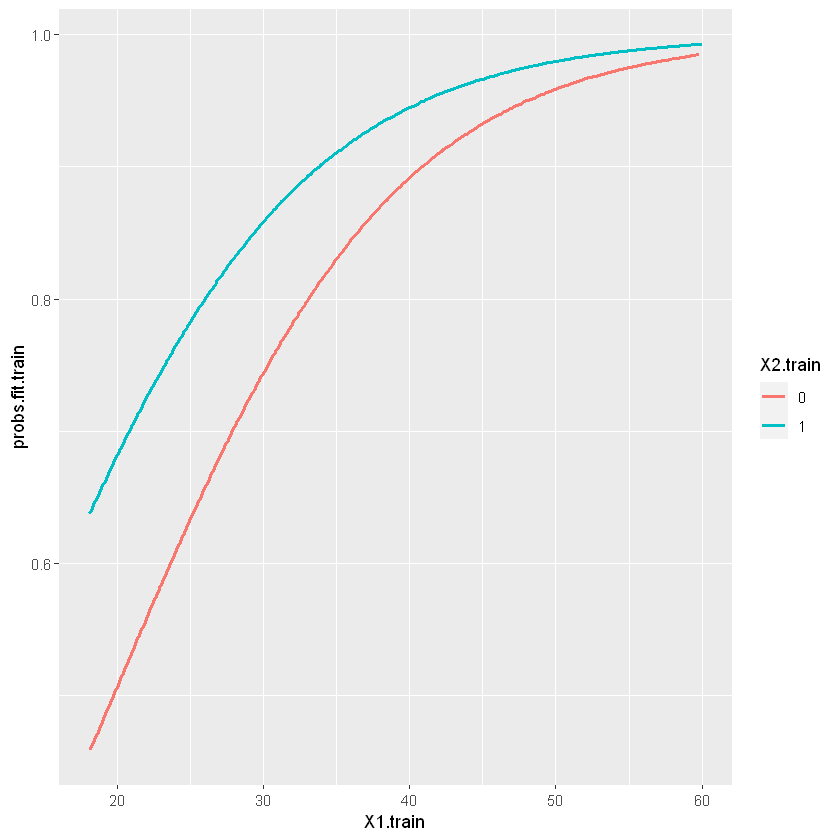

In [26]:
ggplot(plt.data, aes(X1.train)) +
  geom_line(aes(y = probs.fit.train, colour = X2.train), cex = 1)

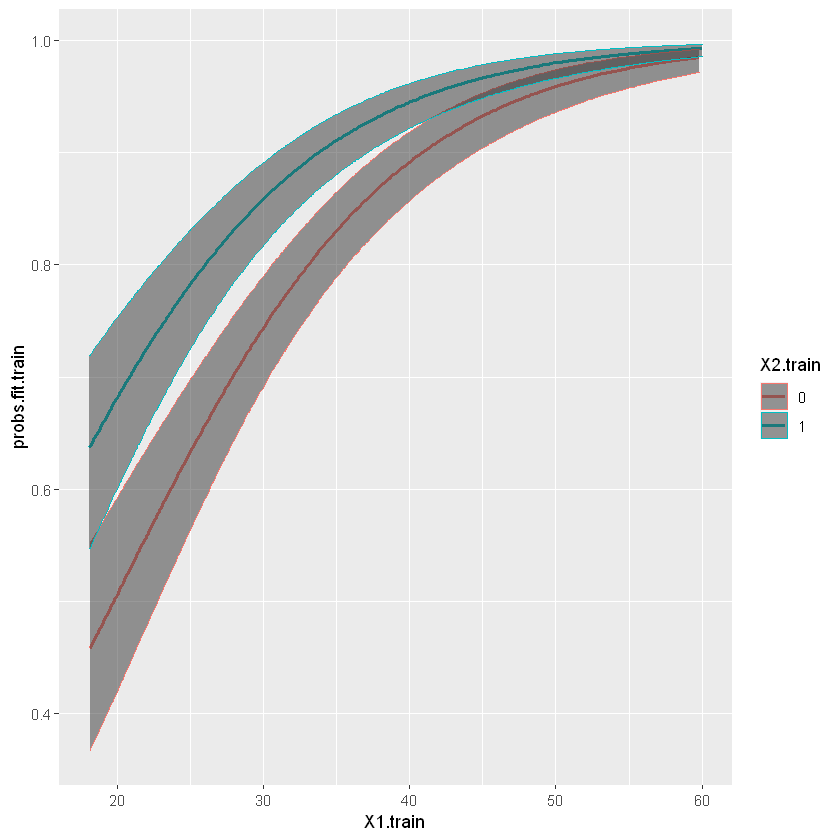

In [27]:
ggplot(plt.data, aes(X1.train)) +
  geom_line(aes(y = probs.fit.train, colour = X2.train), cex = 1) +
  geom_ribbon(aes(ymin = lower.train,
                  ymax = upper.train,
                  colour = X2.train),
                  alpha = 0.5)

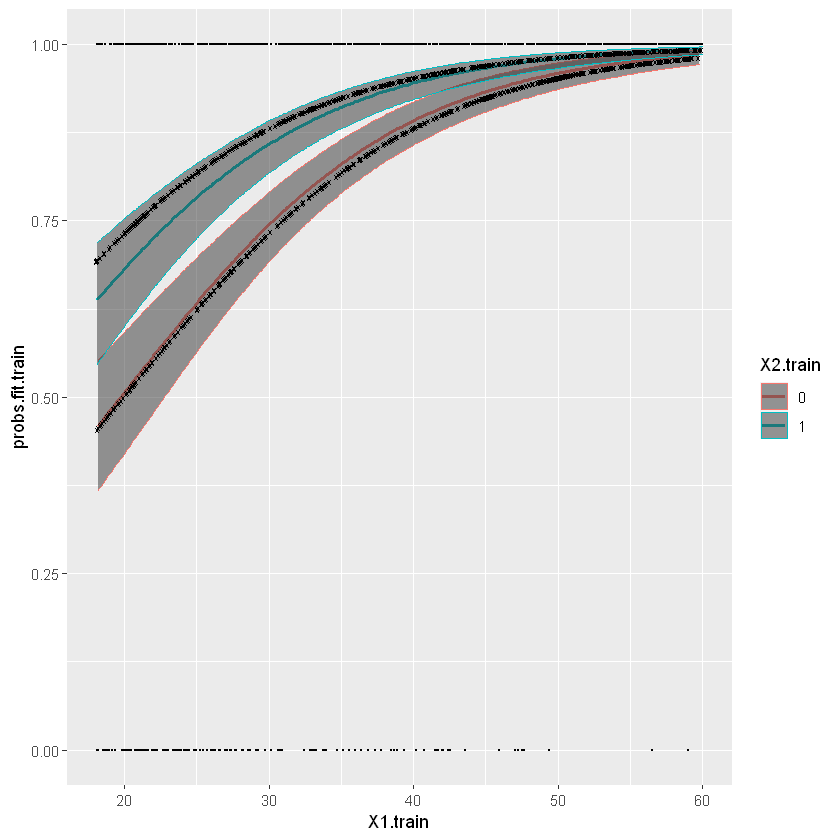

In [28]:
ggplot(plt.data, aes(X1.train)) +
  geom_line(aes(y = probs.fit.train, colour = X2.train), cex = 1) +
  geom_ribbon(aes(ymin = lower.train,
                  ymax = upper.train,
                  colour = X2.train),
                  alpha = 0.5) +
  geom_point(aes(y = y.train), size = 0.3) +
  geom_point(aes(y = probs.true.train), shape = "x", size = 1.5)



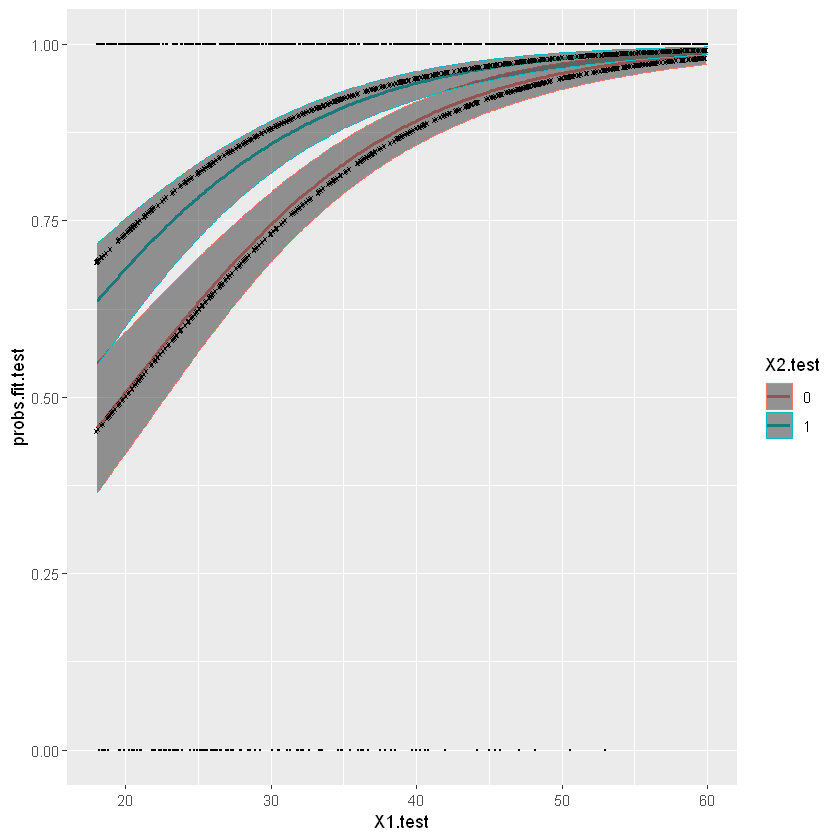

In [29]:
ggplot(plt.data, aes(X1.test)) +
geom_line(aes(y = probs.fit.test, colour = X2.test), cex = 1) +
geom_ribbon(aes(ymin = lower.test,
                ymax = upper.test,
                colour = X2.test),
            alpha = 0.5) +
geom_point(aes(y = y.test), size = 0.3) +
geom_point(aes(y = probs.true.test), shape = "x", size = 1.5)

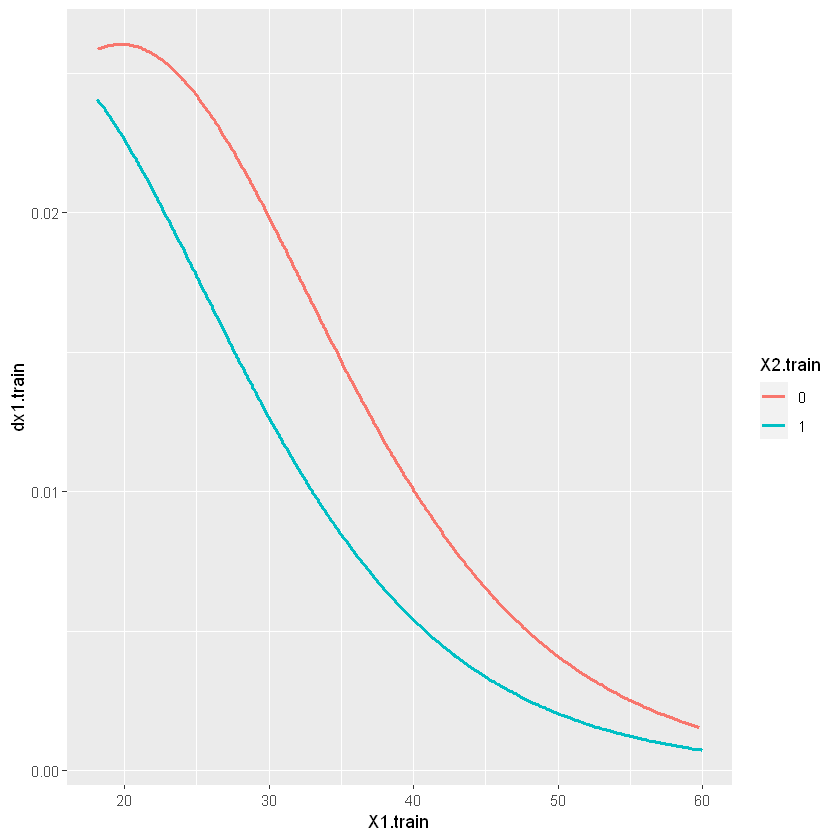

In [30]:
# Plot the marginal effect of X1
ggplot(plt.data, aes(X1.train)) +
  geom_line(aes(y = dx1.train, colour = X2.train), cex = 1)